The pySPaRTAN package and the pipeline outlined in this chapter are designed around the Scanpy/scVerse ecosystem, which stores data as `AnnData` objects.  An AnnData object contains a data matrix with columns (observations) as cells and rows (variables) as genes or ADTs.  The object has dataframes `.obs` and `.var` containing information on each cell and each gene, respectively.  Additionally, the fields `.obsm` and `.varm` can be used to store additional dataframes with features describing the cells and genes.  For example, we will store the surface protein count matrix in `.obsm`.

## 1 Importing and pre-processing CITE-seq data

Import all the packages used in the pipeline.

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

import pySPaRTAN

Load CITE-seq data into memory using one of Scanpy’s i/o functions. In this case, the counts for mRNA and protein ADTs are stored in the same .h5 file, and so we use the `sc.read_10x_h5` function. Refer to the Scanpy documentation for other formats, such as h5ad, loom, csv, or excel files, for example. After the data is loaded into an AnnData object, the `var_names_make_unique` function appends a number to the end of gene names that are not unique.

In [2]:
#!wget https://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3_nextgem/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5 -O ../data/cite-seq/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5
path="../data/cite-seq/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5"
adata=sc.read_10x_h5(path, gex_only=False)

adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Separate the gene expression counts from the ADT counts. Variables are annotated as either “Antibody Capture” or “Gene Expression” in the `adata.var["feature_types"]` field. We move the proteomics data (“Antibody Capture”) to a separate data frame.

In [3]:
protein=adata[:,adata.var["feature_types"]=="Antibody Capture"].copy()
protein=protein[:,[x for x in protein.var_names if "control" not in x]]
adata.obsm["protein_raw_counts"]=protein.to_df()
adata.obsm["protein_raw_counts"].columns=[elem.replace("_TotalSeqB", '') for elem in adata.obsm["protein_raw_counts"].columns]

adata = adata[:, adata.var["feature_types"] == "Gene Expression"]
adata.layers["raw_counts"] = adata.X.copy()

Some cells have a sequencing depth that is too low to use for our analysis. We recommend filtering out cells where less than 5000 unique genes are sequenced, and cells where more than 30% of genes mitochondrial genes.  The `function sc.pp.filter_genes` is used to remove genes that are not present in any cells, `sc.pp.calculate_qc_metrics` computes the metrics used to filter cells and stores the results in `adata.obs` and `adata.var`.

In [4]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_counts=0.03*adata.n_obs)
adata.var['mt'] = adata.var_names.str.startswith('MT-')

sc.pp.calculate_qc_metrics(adata, 
                           qc_vars=['mt'], 
                           percent_top=None,
                           log1p=False,
                           inplace=True)

adata=adata[adata.obs.query(
    "n_genes_by_counts < 5000 and pct_counts_mt<30").index]

Because our analysis is only concerned with genes transcribed in the nucleus, we remove all mitochondrial genes from the dataset.

In [5]:
adata=adata[:, adata.var['mt']==False]

We limit the genes used in our analysis to the top 5000 mostly highly variable genes.  Genes that are not highly variable are of less interest as they give less insight into intercellular heterogeneity. 

In [6]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=5000,
    subset=True,
    flavor='seurat_v3')

Trying to set attribute `.uns` of view, copying.


Use the `sc.pp.normalize_total` function to scale the raw count data so that the sum is $10^4$ for each cell. Then, use `sc.pp.log1p` to log-transform the data so that it is more suitable for a linear model. The normalized, log transformed counts are to be stored in `adata.layers["log1p"]`.

In [7]:
adata.X=sc.pp.normalize_total(adata,
                              target_sum=10000, 
                              layer="raw_counts", 
                              inplace=False)['X']

sc.pp.log1p(adata)

adata.layers["log1p"]=normalize(
    adata.X,
    axis=1
).todense()

For the protein count data, we use the _center log ratio_ (CLR) transform using the `clr` function in pySPaRTAN. The CLR transform scales the data by the geometric mean of each cell, and then log-transforms the data.

In [8]:
adata.obsm["protein"]=pySPaRTAN.pp.clr(adata.obsm["protein_raw_counts"].T).T

adata.obsm["protein"].loc[:]=normalize(adata.obsm["protein"],
                                       axis=1)


## 1.2 Clustering and assigning cell-types
SPaRTAN performs best when used to model data from different cell types separately. Several methods exist for cell-type assignments from CITE-Seq data.  For the purposes of this demonstration, we use the Leiden algorithm to cluster the data using both gene and protein expression, and then manually map the clusters to cell types based on the mean expression of the marker genes and proteins for each cluster.  The process is omitted here but is available on the SPaRTAN Github repository and the Scanpy documentation.  We use the marker genes and proteins in Table 1 to assign cell types to each cluster.

: Marker genes and cell types used to assign cell types to Leiden clusters.


| Cell Type          | Marker Genes         | Marker Proteins |
|--------------------|----------------------|-----------------|
| CD8+               | CD8A,  CD8B,  FCER1G | CD8a, CD4       |
| Naive CD4+ T       | IL7R,  CCR7,  CD3E   | CD45RA, CD4     |
| Memory CD4+        | IL7R, S100A4, CD3E   | CD45RO, CD4     |
| NK                 | GNLY,  NKG7          | CD56            |
| DC                 | FCER1A, CST3         |                 |
| CD14+ Mono         | CD14, LYZ            | CD14            |
| FCGR3A+/CD16+ Mono | FCGR3A, MS4A7        | CD16            |
| B                  | MS4A1                | CD20,  CD19     |


Once the cell type assignment has been completed, and the results are stored in a csv file with two columns, one for the cells barcode and another for its cell type, we read in the data and store it in the field `adata.obs["cell_types"]`.

In [9]:
ct_df=pd.read_csv("cell_types_PBMC.csv",index_col=0)
adata=adata[np.intersect1d(adata.obs_names, ct_df.index)]
adata.obs["cell_types"] = ct_df.loc[adata.obs_names]

Trying to set attribute `.obs` of view, copying.


It is important to note the number of cells for each cell type, which can be found using the `.value_counts()` function as shown below.  The SPaRTAN model will take more time and memory for cell types that have more than approximately 700 cells.  We recommend down-sampling for cell types that have more than 1000 cells when fitting the model becomes intractable.

In [155]:
adata.obs["cell_types"].value_counts()

CD14+ Mono            1036
CD4+ Naive T           912
CD4+ Memory T          719
CD8+                   403
NK                     362
B                      337
FCGR3A+/CD16+ Mono     297
CD                     150
Name: cell_types, dtype: int64

## 1.3 TF-Gene binding data

A dataframe containing interactions between TFs and genes is loaded and stored in the AnnData object as follows. The dataframe has a column for each TF and a row for each gene, with entries being either zero or one indicating if a TF and gene are recorded as interacting in the DoRethEA database. We use an abridged version of the database, with TFs and genes being filtered out if they have too few interactions.

In [240]:
tf_gene=pySPaRTAN.datasets.load_dorthea()

AttributeError: module 'pySPaRTAN' has no attribute 'datasets'

We store the dataframe in our AnnData object after keeping only the genes present in both the TF-gene interaction matrix and the CITE-seq dataset. The dataframe is stored in the AnnData object as `adata.varm["tf_gene"]`.

In [11]:
common_genes=np.intersect1d(tf_gene.index, 
                            adata.var_names)
tf_gene=tf_gene.loc[common_genes]
adata= adata[:, common_genes]
tf_gene.loc[:]=normalize(tf_gene)
adata.varm["tf_gene"]=tf_gene

# 2. Fitting SPaRTAN Models for each cell-type

To recap, after successfully completing part 1, we have an AnnData object with the following fields.

- `adata.layers["log1p"]`
- `adata.obsm["protein"]`
- `adata.varm["tf_gene"]`
- `adata.obs["cell_type"]`

The prerequisite can be verified by printing the AnnData object and seeing each field present in the output.

In [12]:
print(adata)

AnnData object with n_obs × n_vars = 4216 × 2851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'protein_raw_counts', 'protein'
    varm: 'tf_gene'
    layers: 'raw_counts', 'log1p'


In order to evaluate the model’s performance, we will train the model using 80% of all cells in the dataset, and reserve the remaining 20% to be used only for testing the models ability to predict gene expression based on surface protein expression.

In [13]:
adata.obs["training"]= np.random.rand(adata.n_obs) < 0.8

Because transcriptional regulation and inter-cellular signaling are highly dependent on cell-types, we train SPaRTAN separately on each cell types. We start by demonstrating with only CD8+ T cells. From the entire dataset, we extract two subsets: one for training the CD8+ T cell model and one for evaluating the model.

In [14]:
adata_cd8=adata[(adata.obs["cell_types"] == "CD8+")]

adata_cd8_training=adata[(adata.obs["cell_types"] == "CD8+")
                          & (adata.obs["training"] == True)]
adata_cd8_testing =adata[(adata.obs["cell_types"] == "CD8+")
                          & (adata.obs["training"] == False)]

The SPaRTAN class in pySPaRTAN can perform cross validation, fit the model, make predictions, infer TF activities, and estimate the correlation between proteins and TFs.  The algorithm used to fit the model approximates the matrix P by a truncated singular value decomposition, using the number of singular vectors that captures 70% of the full spectrum (see Note X).

The model has two parameters regularization: `lamda` to specify the regularization coefficient, and `alpha` as the trade-off between the $l_1$ and $l_2$ regularizer.  Setting `alpha=0` will train the model only using the $l_1$ regularizer, `alpha=1` will use only the $l_2$ regularizer, and `alpha=0.5` will weight the $l_1$ and $l_2$ regularizer equally.

To use cross validation and grid search to find the optimal values of `lamda` between 1e-5 and 10, and `alpha` between 0 and 1, we would initialize the model specifying a range for `lamda` and `alpha` as follows:

In [18]:
model_cd8= pySPaRTAN.SPaRTAN(lamda=[0.0001, 10],
                             alpha=[0.01,1],
                             solver="Kron",
                             spectrum=0.7
                            )

The simplest way to fit the model is by calling the `.fit()` function and providing the AnnData object containing the training data.

In [20]:
model_cd8=model_cd8.fit(adata_cd8_training)

Alternatively, we can fit the model without using an AnnData structure by directly providing the three matrices needed: the gene expression ($Y$), the protein expression ($P$), and the tf-gene matrix ($D$).

In [21]:
gene_expression=adata_cd8_training.layers["log1p"]
protein=adata_cd8_training.obsm["protein"]
tf_gene_matrix=adata_cd8_training.varm["tf_gene"]

model_cd8=model_cd8.fit(Y=gene_expression,
                          P=protein, 
                          D=tf_gene_matrix)

We evaluate the performance using the `.score` function, which predicts gene expression for each cell in the testing set using the protein data and compares to the true gene expression.

In [22]:
model_cd8.score(adata_cd8_testing)

0.6011619576623369

As with fitting the data, making predictions and evaluating perfomance can be done without using an AnnData object as follows:

In [23]:
protein_test=adata_cd8_testing.obsm["protein"]

gene_expression_test=np.asarray(
    adata_cd8_testing.layers["log1p"])

model_cd8.score(P=protein_test.to_numpy(),Y=gene_expression_test)

0.6011619576623369

The process is repeated for each cell type in a for loop, storing the models in a dictionary.

In [24]:
models=dict()

for ct in np.unique(adata.obs["cell_types"]):
    adata_training=adata[(adata.obs["cell_types"] == ct)
                         & (adata.obs["training"] == True)]
    adata_testing =adata[(adata.obs["cell_types"] == ct)
                         & (adata.obs["training"] == False)]

    models[ct]= pySPaRTAN.SPaRTAN(lamda=[0.0001, 10],
                                  alpha=[0.01,1],
                                  solver="Kron",
                                  spectrum=0.7
                                  )
    models[ct].fit(adata_training)

    print("R2 value for "+ct+" cells: \t"
          +str(models[ct].score(adata_testing)))

/Users/sagana/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


R2 value for B cells: 	0.6461282165880704


/Users/sagana/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


R2 value for CD cells: 	0.7611261408179985
R2 value for CD14+ Mono cells: 	0.4633501542322201
R2 value for CD4+ Memory T cells: 	0.48547487014373264
R2 value for CD4+ Naive T cells: 	0.4448931302243687


/Users/sagana/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


R2 value for CD8+ cells: 	0.6011489261163475


/Users/sagana/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


R2 value for FCGR3A+/CD16+ Mono cells: 	0.7533750112723303


/Users/sagana/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


R2 value for NK cells: 	0.6205716915875453


# 3. Infer TF Activites

From the fitted model, TF activity is inferred from protein expression by calculating $WP^T$. TF activity for every CD8+ T cell is calculated by the `get_TF_activites` function, using only the protein expression as input.

In [25]:
tf = model_cd8.get_projD(adata_cd8.obsm["protein"])

The significance of the inferred TF activity is assessed using a permutation test. We generate the distribution for an empirical null hypothesis by shuffling the genes for each cell (randomly permuting the rows of Y) a specified number of times (typically, 1000), re-fitting the model, and calculating TF activity. For each TF in each cell, we compare the inferred TF activity to the empirical null distribution of 1000 inferred TF activities and calculate a p-value as the proportion of values in the null distribution that are higher in absolute value than the true inferred TF activity. The p-value has a minimum value inversely proportional to the number of trials (1/1000, typically).

For each cell, P-values are corrected using Bonferroni procedure for multiple hypothesis testing, which is implemented as part of the statsmodel package (`statsmodels.stats.multitest.multipletests`). We use an adjusted p-value of 0.15 for this example.  The permutation test is done using the `get_TF_activites` function, this time specifying the number of permutations to use for the null distribution.


In [26]:
tf, tf_p_val = model_cd8.get_projD(
    adata_cd8.obsm["protein"],
    n_trials=100,
    verbose=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

To identify TFs that are important in CD8+ T cells, we look for TFs that have a p value of less than 0.15 in a high proportion of cells.

In [27]:
prop_sig=(tf_p_val<0.15).mean()
prop_sig.sort_values(ascending=False).head(20)

REL        1.000000
ZKSCAN1    1.000000
NR2F6      1.000000
JUND       1.000000
GATA6      1.000000
BCL11A     1.000000
SMAD5      1.000000
SPIB       1.000000
FOSL2      1.000000
PKNOX1     0.995037
IRF2       0.992556
THAP11     0.947891
KLF5       0.942928
NCOR1      0.885856
ARID1A     0.851117
PROX1      0.620347
TBX21      0.560794
TP63       0.531017
ESRRA      0.521092
FOS        0.503722
dtype: float64

The inferred TF activity and corresponding p-values are stored in the AnnData object.

In [28]:
adata_cd8.obsm["tf_activity"]=tf
adata_cd8.obsm["tf_p_val"]=tf_p_val

Repeat the process for each cell type, and create a dataframe with the proportion of cells for each cell type where each TF is significant.

In [29]:
import time
tf_ct=dict()
tf=dict()
tf_p_val=dict()
tf_ct_p_vals=dict()
tf_ct_mean=dict()
for ct in np.unique(adata.obs["cell_types"]):
    print("Calculating TF activities for "+ct+" cells")
    time.sleep(0.1)
    tf[ct], tf_p_val[ct] =models[ct].get_projD(
        adata[adata.obs["cell_types"] == ct].obsm["protein"],
        n_trials=100,
        verbose=True
    )

adata.obsm["tf"]=pd.concat(tf.values(),
                           axis=0).sort_index()

adata.obsm["tf_p_val"]=pd.concat(tf_p_val.values(),
                                 axis=0).sort_index()
adata.obsm['tf_sig']=adata.obsm['tf_p_val']<0.15



Calculating TF activities for B cells


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating TF activities for CD cells


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating TF activities for CD14+ Mono cells


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating TF activities for CD4+ Memory T cells


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating TF activities for CD4+ Naive T cells


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating TF activities for CD8+ cells


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating TF activities for FCGR3A+/CD16+ Mono cells


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating TF activities for NK cells


  0%|          | 0/100 [00:00<?, ?it/s]

Using the TF activities, we calculate and plot the tSNE embedding for all cells in the dataset, coloring the cells by cell type.

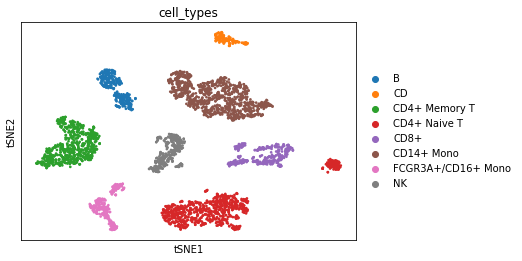

In [141]:
sc.tl.tsne(adata, use_rep="tf")
sc.pl.tsne(adata, color="cell_types")

Create a dotplot of the importance of TFs across cell-types using seaborn. We plot only the subset of TFs that are important to the transcriptional program of at least one cell-type.

In [241]:
#tfs_to_plot=["MYC","EGR1", "ELK1","SPI1", "SP1", "E2F7", "RFX5", "PPARA", "VDR", "MAFG", "FOXP1", "TCF25", "FOSL2", "USF2", "LEF1", "GATA3", "MEIS2", "SMAD2", "CREB1", "FOS", "TEAD1", "HIF1A", "PPARG"]
tfs_to_plot=tf_ct_p_vals.max(axis=1).sort_values(ascending=False).head(30).index
pySPaRTAN.pl.tf_dotplot(adata,
                        tfs_to_plot=tfs_to_plot,
                        group="cell_types"
                        )

AttributeError: module 'pySPaRTAN' has no attribute 'pl'

# 4. Identifying TF-protein relationships

The matrix $W$ in the model can be interpreted as interactions between TFs and proteins.  However, due to different proteins being expressed on different scales, we instead look at the correlations between protein expressions ($P$) and the inferred TF activity ($WP^T$).  The `get_tf_protein_cor` is used to compute the correlation matrix using all cells in the training data.  The function returns a data frame with TFs as columns and proteins as rows.

In [68]:
protein_tf=model_cd8.get_tf_protein_cor()
protein_tf.head()


We visualize the results using a clustermap, using only the TFs that are significantly active in at least 10% of CD8+ T cells.

Text(0.5, 1.05, 'CD8+ T Cells')

<Figure size 4000x4000 with 0 Axes>

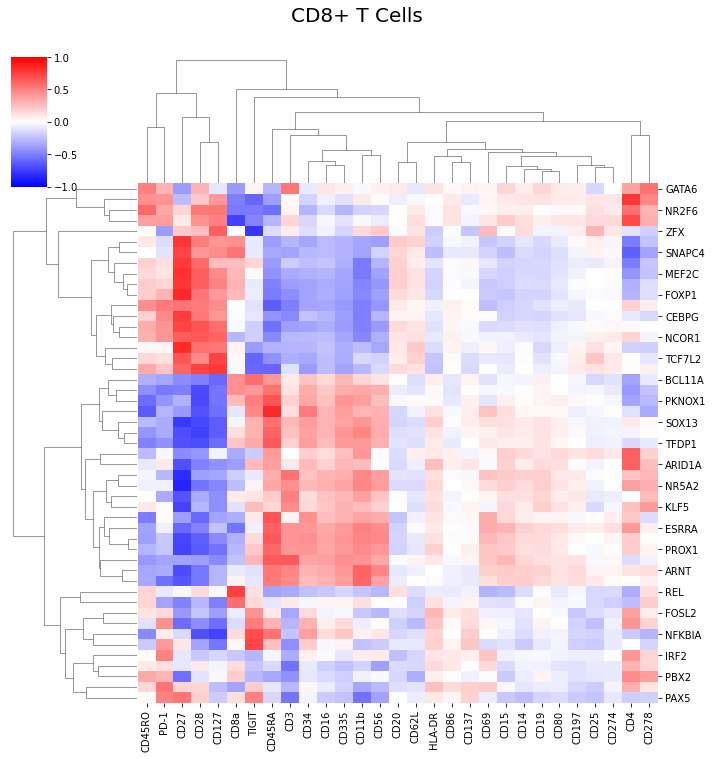

In [144]:
plt.figure(dpi=400, figsize=(10,10))
sns.clustermap(
    protein_tf.loc[tf_ct_p_vals.query("`CD8+`>0.1").index],
    cmap="bwr",vmin=-1, vmax=1
).fig.suptitle('CD8+ T Cells', y=1.05,fontsize=20)

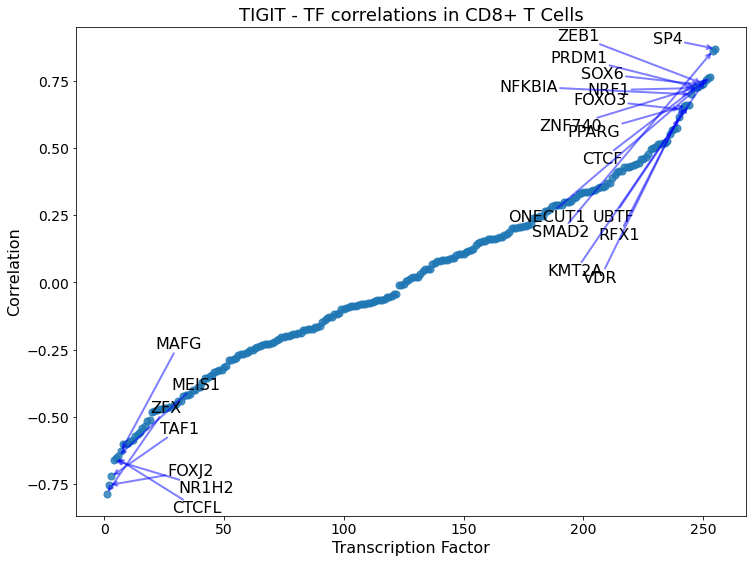

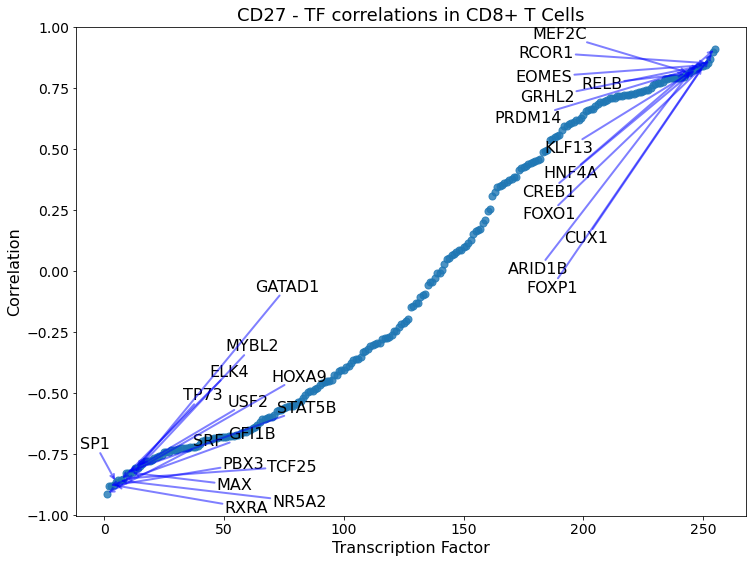

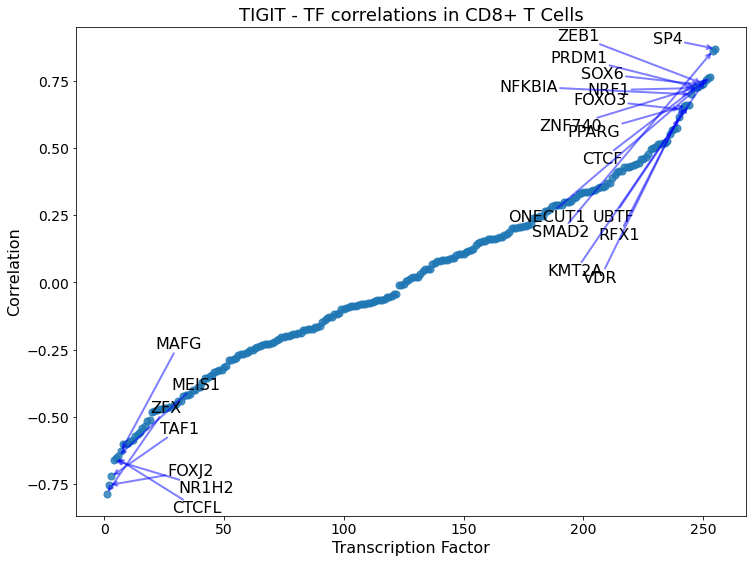

In [150]:
pySPaRTAN.pl.tf_protien_line_plot(
    protein_tf, "CD27",
    title="CD27 - TF correlations in CD8+ T Cells")

pySPaRTAN.pl.tf_protien_line_plot(
    protein_tf, "TIGIT",
    title="TIGIT - TF correlations in CD8+ T Cells",
    cutoff=0.6 )


Repeat the process for each cell type of interest, and store the results in a dictionary.

In [58]:
protein_tf=dict()
for ct in np.unique(adata.obs["cell_types"]):
    protein_tf[ct]=models[ct].get_tf_protein_cor()
    protein_tf[ct].columns=[elem.replace("_TotalSeqB", '') for elem in protein_tf[ct].columns]


A clustermap can be made for any any cell type in the dictionary as follows:

Text(0.5, 1.05, 'B Cells')

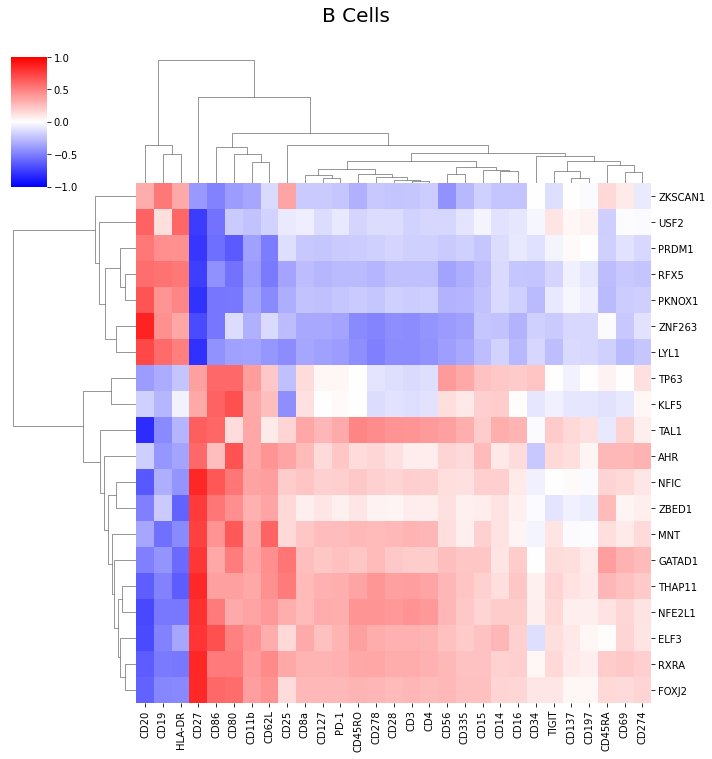

In [67]:
ct="B"
sns.clustermap(
    protein_tf[ct].loc[tf_ct_p_vals.query(f'`{ct}`>0.1').index],
    cmap="bwr",vmin=-1, vmax=1
).fig.suptitle(ct+ ' Cells', y=1.05,fontsize=20)